# Experimento Efeito Fotoeléctrico

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.optimize import curve_fit, fsolve
from scipy.signal import find_peaks
from scipy.constants import h as plancks, e
from scipy.interpolate import interp1d

h = plancks / e

In [3]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 120
sns.set_theme()

#### Constanstes e funções

In [4]:
colors  		= [ 'red', 'yellow', 'green', 'blue', 'violet' ]
colors_			= [ 'red', 'orange', 'green', 'blue', 'violet' ]
cores   		= [ 'Vermelho', 'Laranja', 'Verde', 'Azul', 'Violeta' ]
intensities		= [ 20, 40, 60, 80, 100 ]

In [5]:
def gaussian(x, A, m, s): return A * np.exp( - (x - m)**2 / (2 * s**2) )

## Espectro de emissão dos LEDs

In [6]:
df_leds = {}
for color in colors: df_leds[color] = pd.read_csv(f'Dados/LEDs/{color}.dat', sep='\t')

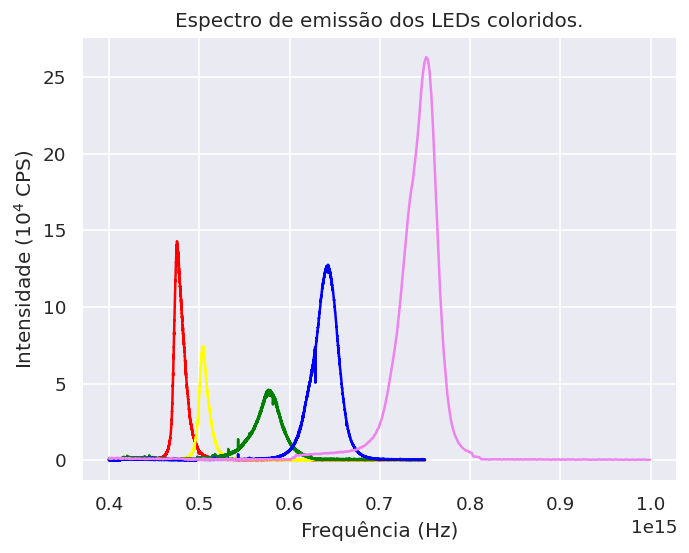

In [7]:
plt.title('Espectro de emissão dos LEDs coloridos.')

for color in colors: sns.lineplot(x=df_leds[color]['Frequencia'], y=df_leds[color]['Intensidade']/1E4, color=color)

plt.xlabel('Frequência (Hz)')
plt.ylabel('Intensidade ($10^{4}$ CPS)')

plt.savefig('Plots/leds_emission.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

In [8]:
peaks = []
heights = [ 14.2E4, 7.45E4, 4.6E4, 12.75E4, 25E4 ]
for i,color in enumerate(colors):
	peaks.append( list(df_leds[color]['Frequencia'][ find_peaks(df_leds[color]['Intensidade'], height=heights[i])[0] ])[0] )

In [9]:
np.array(peaks) / 1E14

array([4.75402, 5.0406 , 5.77017, 6.42416, 7.5134 ])

In [10]:
ranges  = [ [3400, 4000], [2900, 3350], [1600, 2300], [800, 1500], [90, 115] ]
hints   = [
    [ 15E4,  peaks[0], 0.1E14 ],
    [ 7E4,   peaks[1], 0.1E14 ],
    [ 5E4,   peaks[2], 0.1E14 ],
    [ 13E4,  peaks[3], 0.1E14 ],
    [ 21E4,  peaks[4], 0.1E14 ]
  ]
params = {}

In [11]:
for i,color in enumerate(colors):
  popt, pcov = curve_fit(
      gaussian,
      xdata=df_leds[color]['Frequencia'][ranges[i][0]:ranges[i][1]],
      ydata=df_leds[color]['Intensidade'][ranges[i][0]:ranges[i][1]],
      p0=hints[i],
      maxfev=10000
  )
  params[color] = popt

In [12]:
leds_frequency = np.zeros((5, 2))
for i,param in enumerate(params):
  leds_frequency[i] = params[param][1:3]

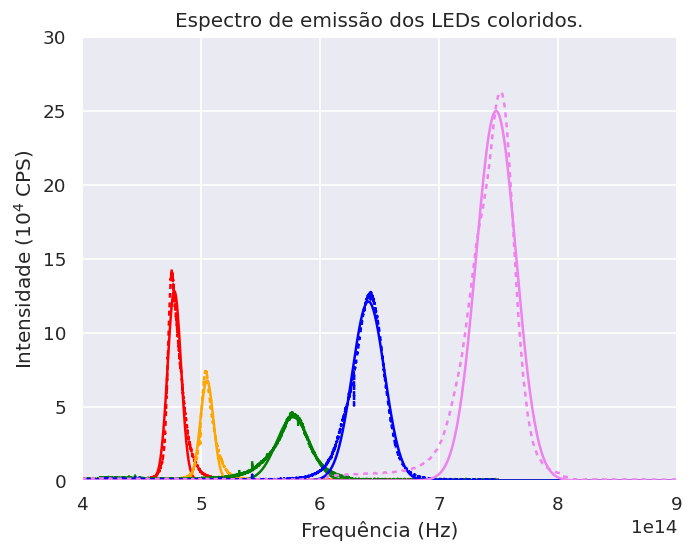

In [13]:
plt.title('Espectro de emissão dos LEDs coloridos.')

x = np.linspace(0.4, 1, 1000) * 1E15

for i,color in enumerate(colors):
  sns.lineplot(x=x, y=gaussian(x, params[color][0], params[color][1], params[color][2])/1E4, color=colors_[i])
  sns.lineplot(x=df_leds[color]['Frequencia'], y=df_leds[color]['Intensidade']/1E4, dashes=(2,2), color=colors_[i])

plt.xlabel('Frequência (Hz)')
plt.ylabel('Intensidade ($10^{4}$ CPS)')
plt.xlim(0.4E15, 0.9E15)
plt.ylim(0, 30)

plt.savefig('Plots/leds_emission_fits.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

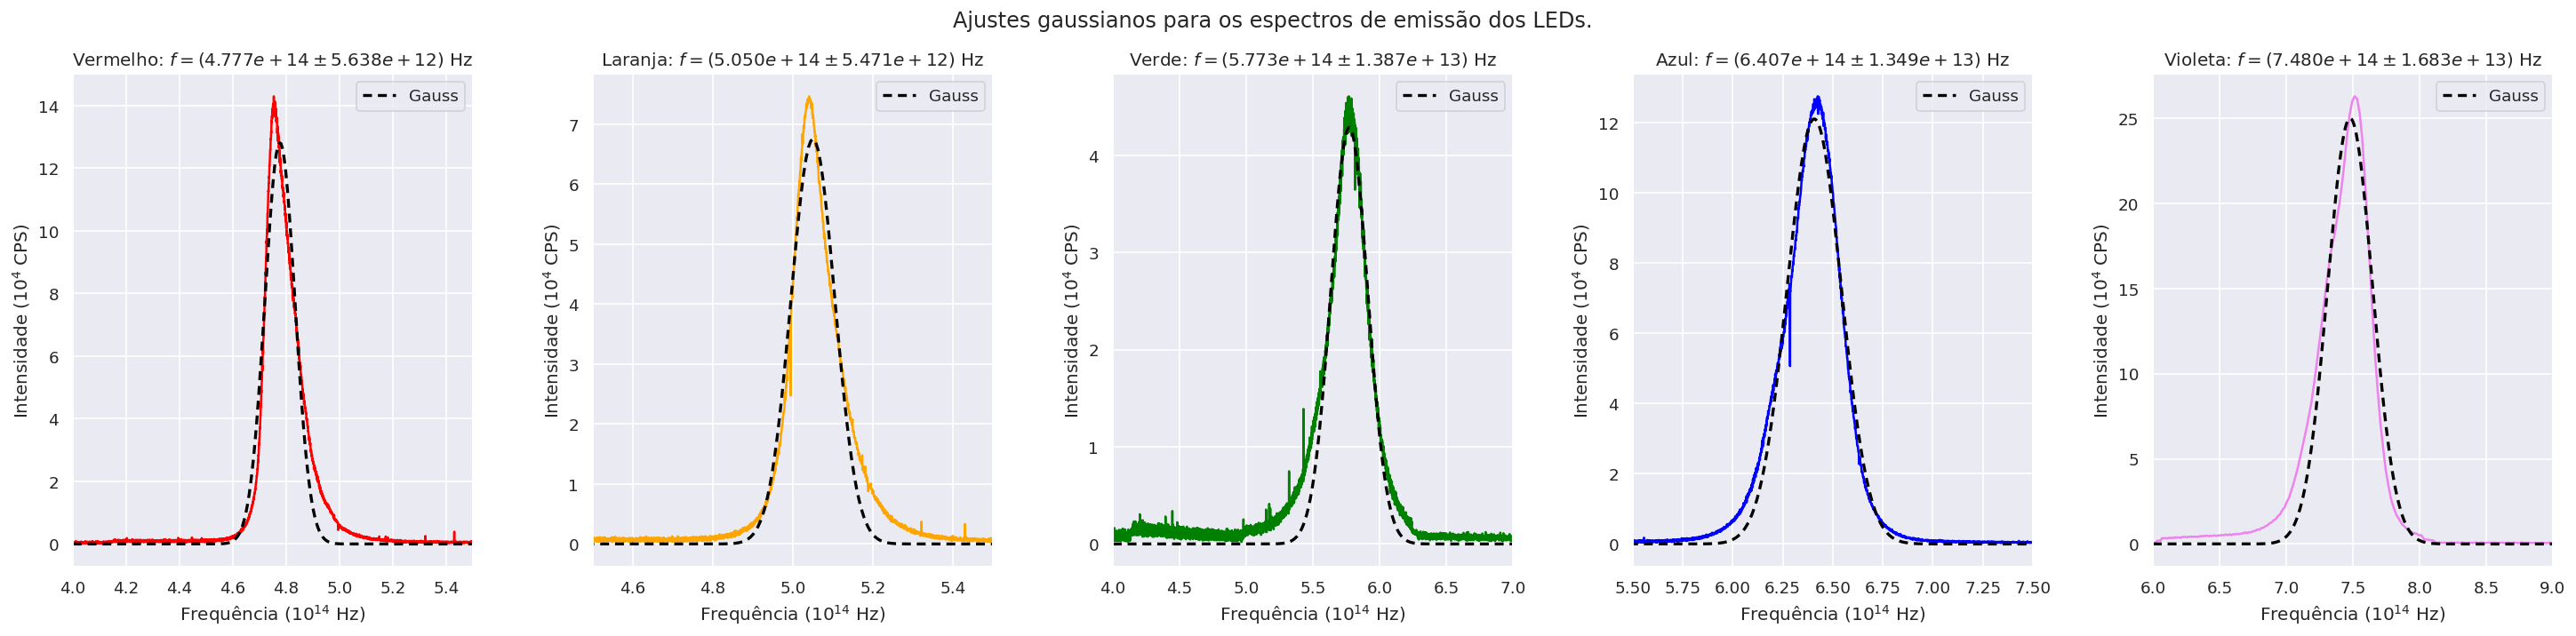

In [14]:
fig, axs = plt.subplots(1, 5, figsize=(30,6), gridspec_kw={ 'wspace': 0.3 })
plt.suptitle('Ajustes gaussianos para os espectros de emissão dos LEDs.')

x = np.linspace(0.4, 1, 1000) * 1E15

xlims = [ [4, 5.5], [4.5, 5.5], [4, 7], [5.5, 7.5], [6, 9] ]
for i,color in enumerate(colors):
	sns.lineplot(x=df_leds[color]['Frequencia']/1E14, y=df_leds[color]['Intensidade']/1E4, color=colors_[i], ax=axs[i])
	sns.lineplot(
		x=x/1E14, 
		y=gaussian(x, params[color][0], params[color][1], params[color][2])/1E4, 
		dashes=(3, 2), alpha=1, color='black', linewidth=2, ax=axs[i],
		label='Gauss'
	)
	# axs[i].vlines(x=[ df_leds[color]['Frequencia'][ranges[i][0]]/1E14, df_leds[color]['Frequencia'][ranges[i][1]]/1E14 ], ymin=0, ymax=15, color='gray', linestyles='dashed')
	axs[i].set(xlim=xlims[i], title=f'{cores[i]}: $f=({params[color][1]:.3e}\pm{params[color][2]:.3e})$ Hz', xlabel='Frequência ($10^{14}$ Hz)', ylabel='Intensidade ($10^4$ CPS)')

plt.savefig('Plots/leds_emission_fits_subplots.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

## Curvas de intensidade medidas

In [15]:
df_raw = pd.read_csv('Dados/dados.csv')

### Correção do ruído

Carregamos os dados das médias de 10 medidas para cada intensidade de cada cor de LED e aplicamos a correção da corrente parasita.

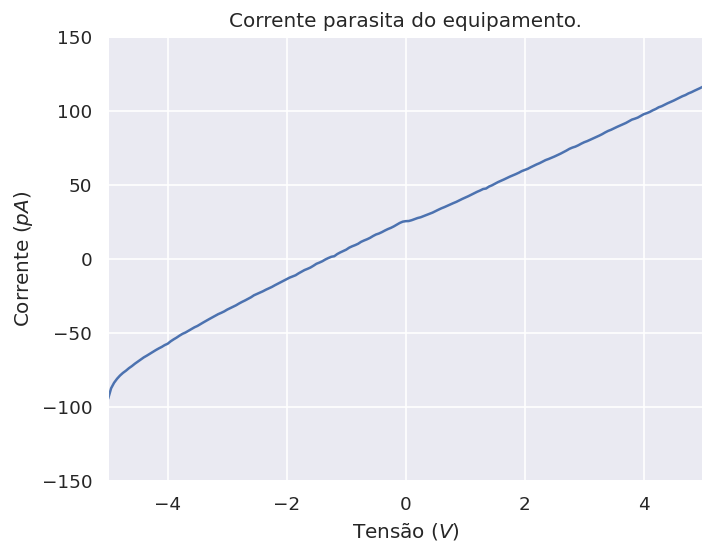

In [16]:
plt.title('Corrente parasita do equipamento.')

sns.lineplot(x=df_raw['Tensao'], y=df_raw['Ruido']*1E12)

plt.xlim(-5, 5)
plt.ylim(-150, 150)
plt.ylabel('Corrente ($p A$)')
plt.xlabel('Tensão ($V$)')

plt.savefig('Plots/curve_noise.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

In [17]:
df = pd.DataFrame(df_raw)
df.drop(columns=[ 'Ruido', 'sRuido' ], inplace=True)

In [18]:
for cor in cores:
	for i in intensities:
		df[f'{cor}_{i}'] = df_raw[f'{cor}_{i}'] - df_raw['Ruido']
		df[f's{cor}_{i}'] = np.sqrt( df_raw[f's{cor}_{i}']**2 + df_raw['sRuido']**2 )

### Curvas dos LEDS

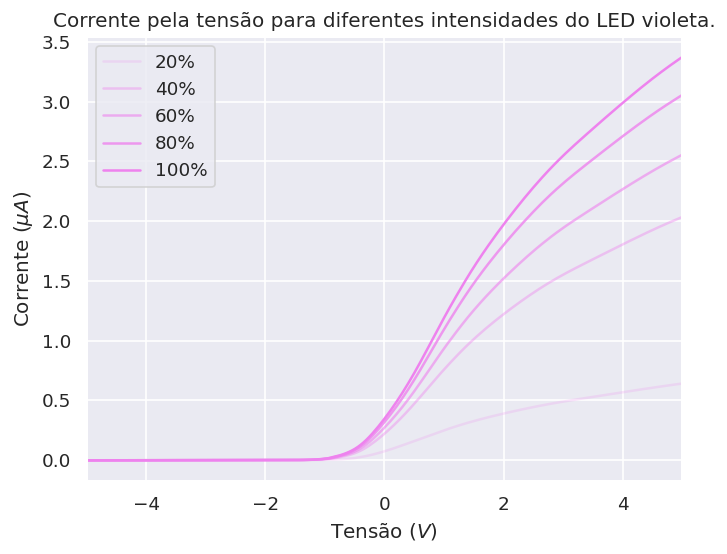

In [19]:
plt.title('Corrente pela tensão para diferentes intensidades do LED violeta.')

for i in intensities:
  sns.lineplot(x=df['Tensao'], y=df[f'Violeta_{i}']*1E6, alpha=i/100, color='violet', label=f'{i}%')

plt.legend()
plt.xlim(-5, 5)
plt.xlabel('Tensão ($V$)')
plt.ylabel('Corrente ($\mu A$)')

plt.savefig('Plots/curve_violet.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

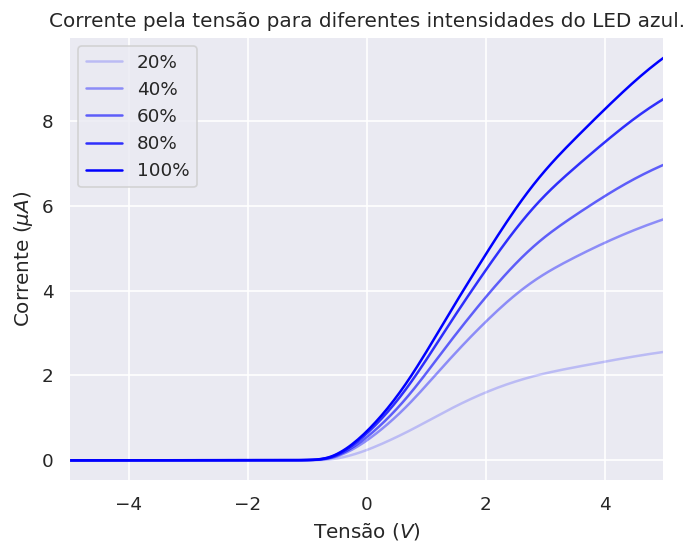

In [20]:
plt.title('Corrente pela tensão para diferentes intensidades do LED azul.')

for i in intensities:
  sns.lineplot(x=df['Tensao'], y=df[f'Azul_{i}']*1E6, alpha=i/100, color='blue', label=f'{i}%')

plt.legend()
plt.xlim(-5, 5)
plt.xlabel('Tensão ($V$)')
plt.ylabel('Corrente ($\mu A$)')

plt.savefig('Plots/curve_blue.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

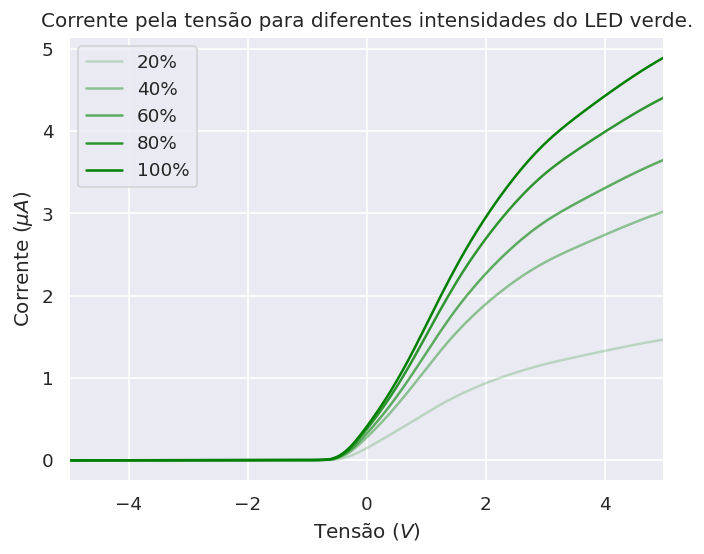

In [21]:
plt.title('Corrente pela tensão para diferentes intensidades do LED verde.')

for i in intensities:
  sns.lineplot(x=df['Tensao'], y=df[f'Verde_{i}']*1E6, alpha=i/100, color='green', label=f'{i}%')

plt.legend()
plt.xlim(-5, 5)
plt.xlabel('Tensão ($V$)')
plt.ylabel('Corrente ($\mu A$)')

plt.savefig('Plots/curve_green.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

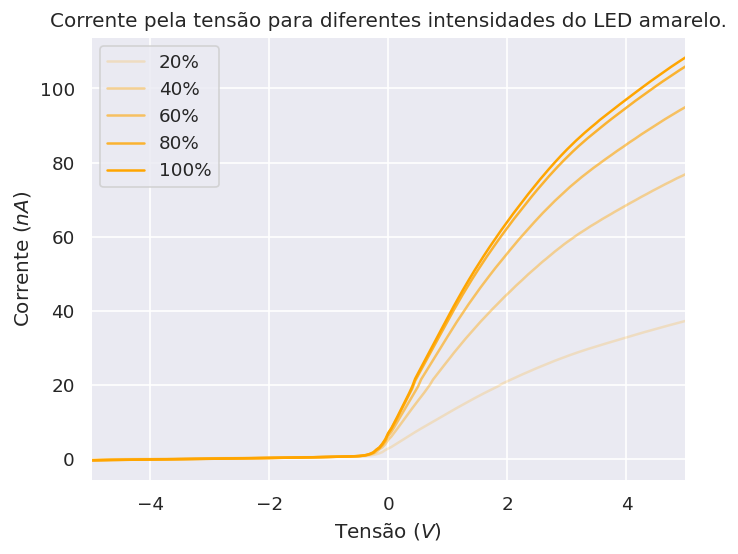

In [22]:
plt.title('Corrente pela tensão para diferentes intensidades do LED amarelo.')

for i in intensities:
  sns.lineplot(x=df['Tensao'], y=df[f'Laranja_{i}']*1E9, alpha=i/100, color='orange', label=f'{i}%')

plt.legend()
plt.xlim(-5, 5)
plt.xlabel('Tensão ($V$)')
plt.ylabel('Corrente ($nA$)')

plt.savefig('Plots/curve_yellow.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

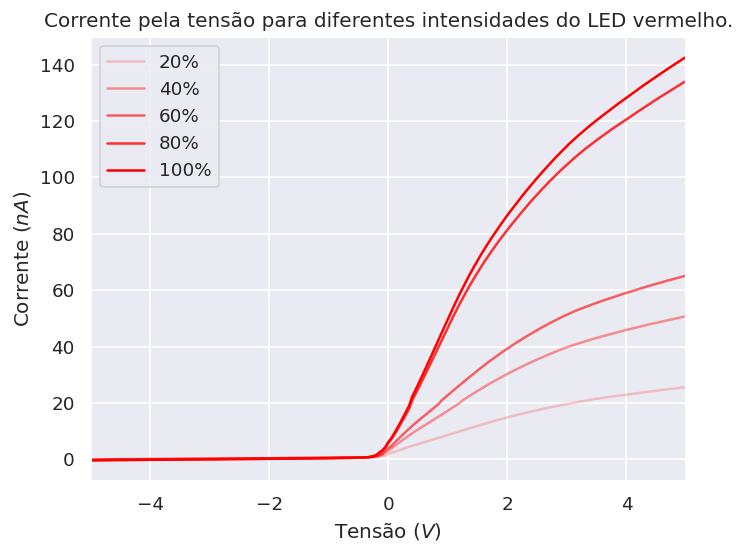

In [23]:
plt.title('Corrente pela tensão para diferentes intensidades do LED vermelho.')

for i in intensities:
  sns.lineplot(x=df['Tensao'], y=df[f'Vermelho_{i}']*1E9, alpha=i/100, color='red', label=f'{i}%')

plt.legend()
plt.xlim(-5, 5)
plt.xlabel('Tensão ($V$)')
plt.ylabel('Corrente ($nA$)')

plt.savefig('Plots/curve_red.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

## Estudo da tensão de corte $V_0$

A tensão de corte é definida como a diferença de potencial em que a intensidade da corrente que circula pelo aparelho é nula. Portanto, sua incerteza dependerá das incertezas da intensidade e da tensão e também do método utilizado para determiná-la.

### Método 1

Para o primeiro método, determinamos o ponto em que a série cruza o eixo-$x$.

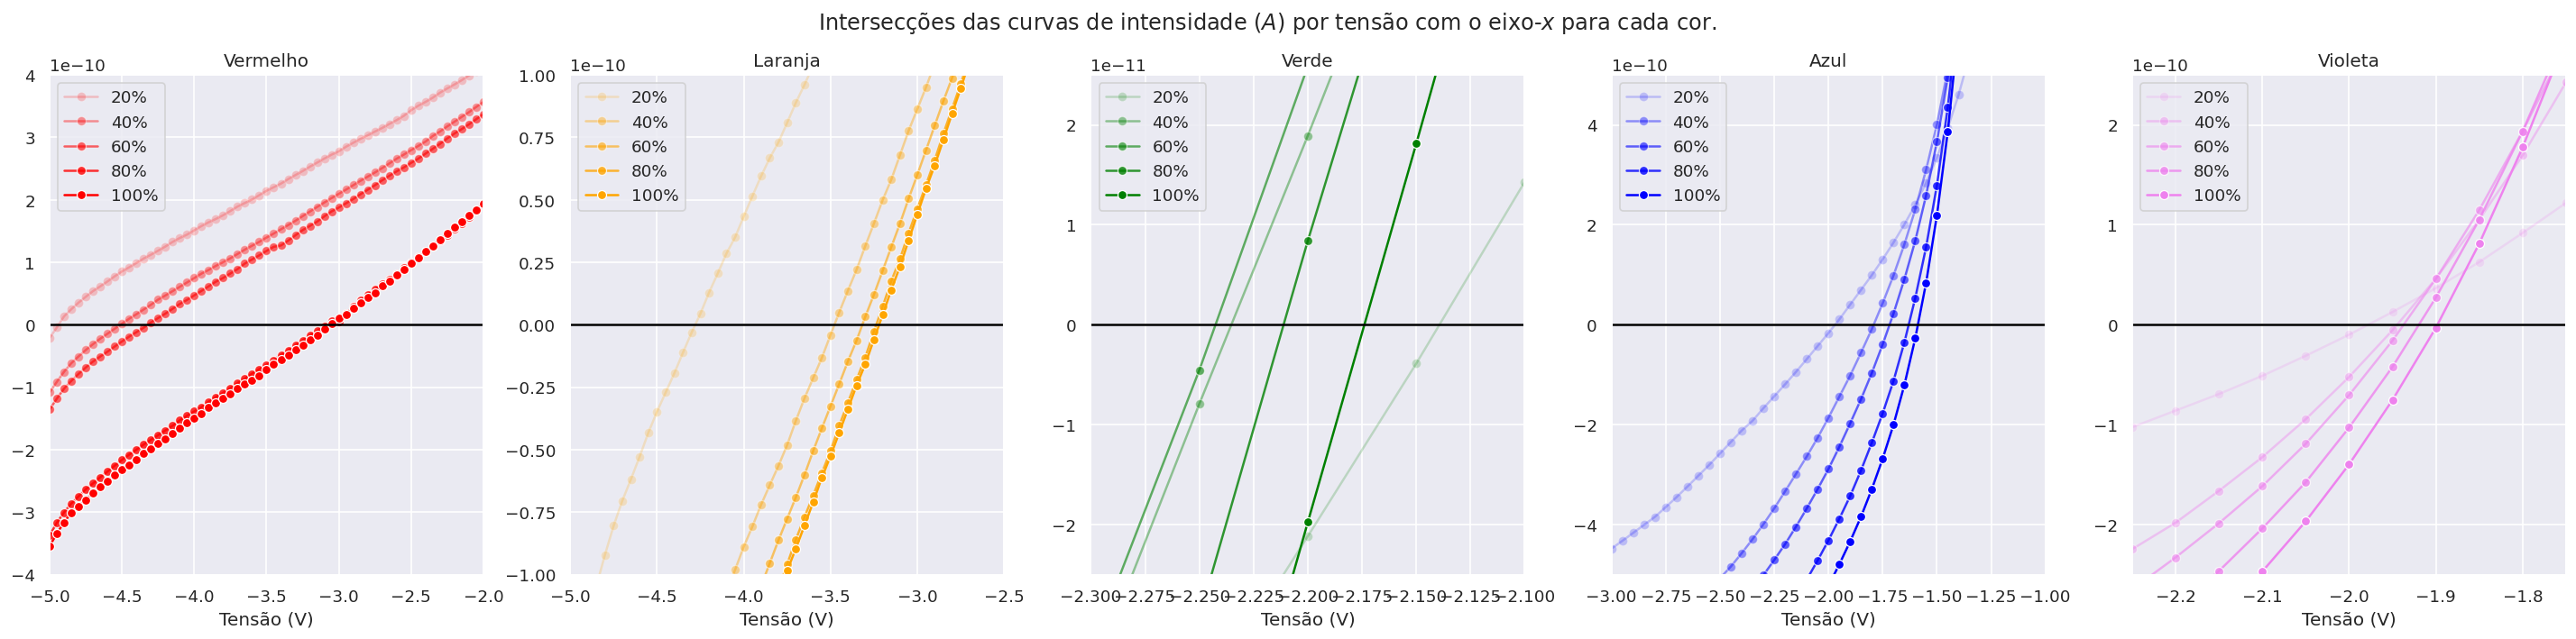

In [24]:
fig, axs = plt.subplots(1, len(cores), figsize=(30,6), gridspec_kw={  })
plt.suptitle('Intersecções das curvas de corrente ($A$) por tensão com o eixo-$x$ para cada cor.')

xlims = [ (-5, -2), (-5, -2.5), (-2.3, -2.1), (-3, -1), (-2.25, -1.75) ]
ylims = [ (-0.4E-9, 0.4E-9), (-0.1E-9, 0.1E-9), (-0.25E-10, 0.25E-10), (-0.5E-9, 0.5E-9), (-0.25E-9, 0.25E-9) ]
for i,cor in enumerate(cores):

	for j,inte in enumerate(intensities):
		sns.lineplot(data=df, x='Tensao', y=f'{cor}_{inte}', color=colors_[i], marker='o', alpha=inte/100, label=f'{inte}%', ax=axs[i])

	axs[i].hlines(y=0, xmin=-5, xmax=5, color='black')
	axs[i].set( xlim=xlims[i], ylim=ylims[i], title=cor, xlabel='Tensão (V)', ylabel='')

plt.savefig('Plots/curves_intersection_x.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

In [85]:
cutoffs = []

for i,color in enumerate(cores):
	v0s = []

	for j,ints in enumerate(intensities):
		func = interp1d(x=df['Tensao'], y=df[f'{color}_{ints}'])

		v0 = df['Tensao'][ np.where(np.diff(np.sign(np.array(df[f'{color}_{ints}']))))[0][0] ]
		v0s.append(fsolve(func=func, x0=v0)[0])
	
	print(f'{color}:\t{v0s}')
	cutoffs.append([ -np.mean(v0s), np.std(v0s) + 0.05 ])

cutoffs = np.array(cutoffs)

Vermelho:	[-4.937406413025408, -4.509882900968772, -4.320403222081781, -3.0887573390961425, -3.0611695467690088]
Laranja:	[-4.279483389650991, -3.477418473089268, -3.3167987059875674, -3.236515634239027, -3.2199682309853928]
Verde:	[-2.1393209682735557, -2.2352391944554655, -2.242535234061844, -2.2111637511940416, -2.173919984805054]
Azul:	[-1.9694449101540834, -1.791571174443254, -1.718198730054135, -1.6300617863637399, -1.5876795467175826]
Violeta:	[-1.978056144160549, -1.9446546490864494, -1.9371513812445578, -1.9195901680455634, -1.898196590078375]


In [86]:
cutoffs

array([[3.98352388, 0.81834603],
       [3.50603689, 0.44732268],
       [2.20043583, 0.08882483],
       [1.73939123, 0.18495623],
       [1.93552979, 0.07661662]])

In [87]:
popt, pcov = curve_fit(
    lambda x, a, b: x * a + b,
    xdata=leds_frequency.transpose()[0],
    ydata=cutoffs.transpose()[0],
	sigma=cutoffs.transpose()[1]
)

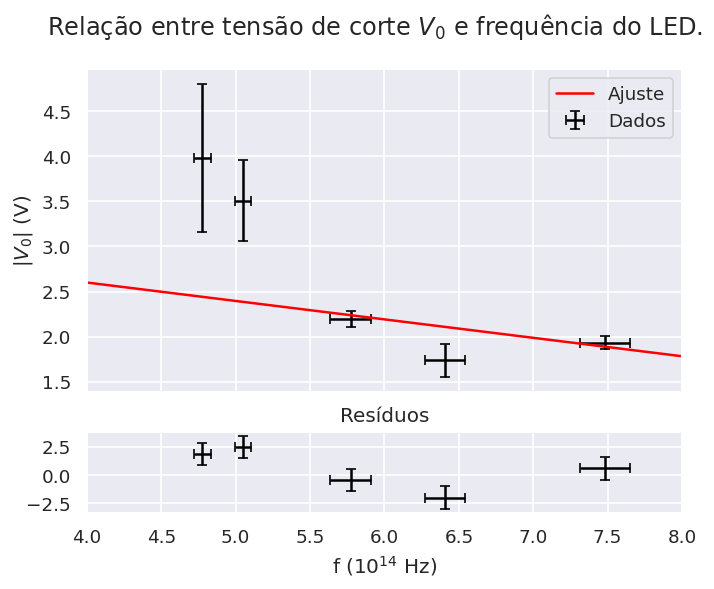

In [88]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={ 'hspace': 0.2, 'height_ratios': (4, 1)})
plt.suptitle('Relação entre tensão de corte $V_0$ e frequência do LED.')

axs[0].errorbar(
    x=leds_frequency.transpose()[0] / 1E14,
    y=cutoffs.transpose()[0],
    xerr=leds_frequency.transpose()[1] / 1E14,
	yerr=cutoffs.transpose()[1],
    fmt=' ', marker=' ', color='black', capsize=3, label='Dados'
)

x = np.linspace(4, 8, 10) * 1E14
sns.lineplot(x=x/1E14, y=x*popt[0]+popt[1], color='red', label='Ajuste', ax=axs[0])

axs[1].errorbar(
    x=leds_frequency.transpose()[0] / 1E14,
    y=(cutoffs.transpose()[0] - leds_frequency.transpose()[0] * popt[0] - popt[1]) / cutoffs.transpose()[1],
    xerr=leds_frequency.transpose()[1] / 1E14,
	yerr=1,
    fmt=' ', marker=' ', color='black', capsize=3
)

axs[0].set(ylabel='$|V_0|$ (V)')
axs[1].set(xlim=(4, 8), xlabel='f ($10^{14}$ Hz)', ylabel='', title='Resíduos')

plt.savefig('Plots/cutoff_intensity_method1.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

In [89]:
print('Constante de Planck:\t{:.8e} | {:.8e} | {:.2f}% | {:.1f}'.format(popt[0], np.sqrt(pcov[0][0]), 100*(h-popt[0])/h, (h - popt[0]) / np.sqrt(pcov[0][0])))
print('Função Trabalho:\t{:.8e} | {:.8e}'.format(-popt[1], np.sqrt(pcov[1][1])))

Constante de Planck:	-2.04148014e-15 | 1.42971977e-15 | 149.36% | 4.3
Função Trabalho:	-3.41712577e+00 | 9.63562188e-01


In [30]:
chi2 = np.sum((cutoffs.transpose()[0] - leds_frequency.transpose()[0] * popt[0] - popt[1])**2 / cutoffs.transpose()[1]**2)
print(chi2)

14.346732103050336


### Método 2

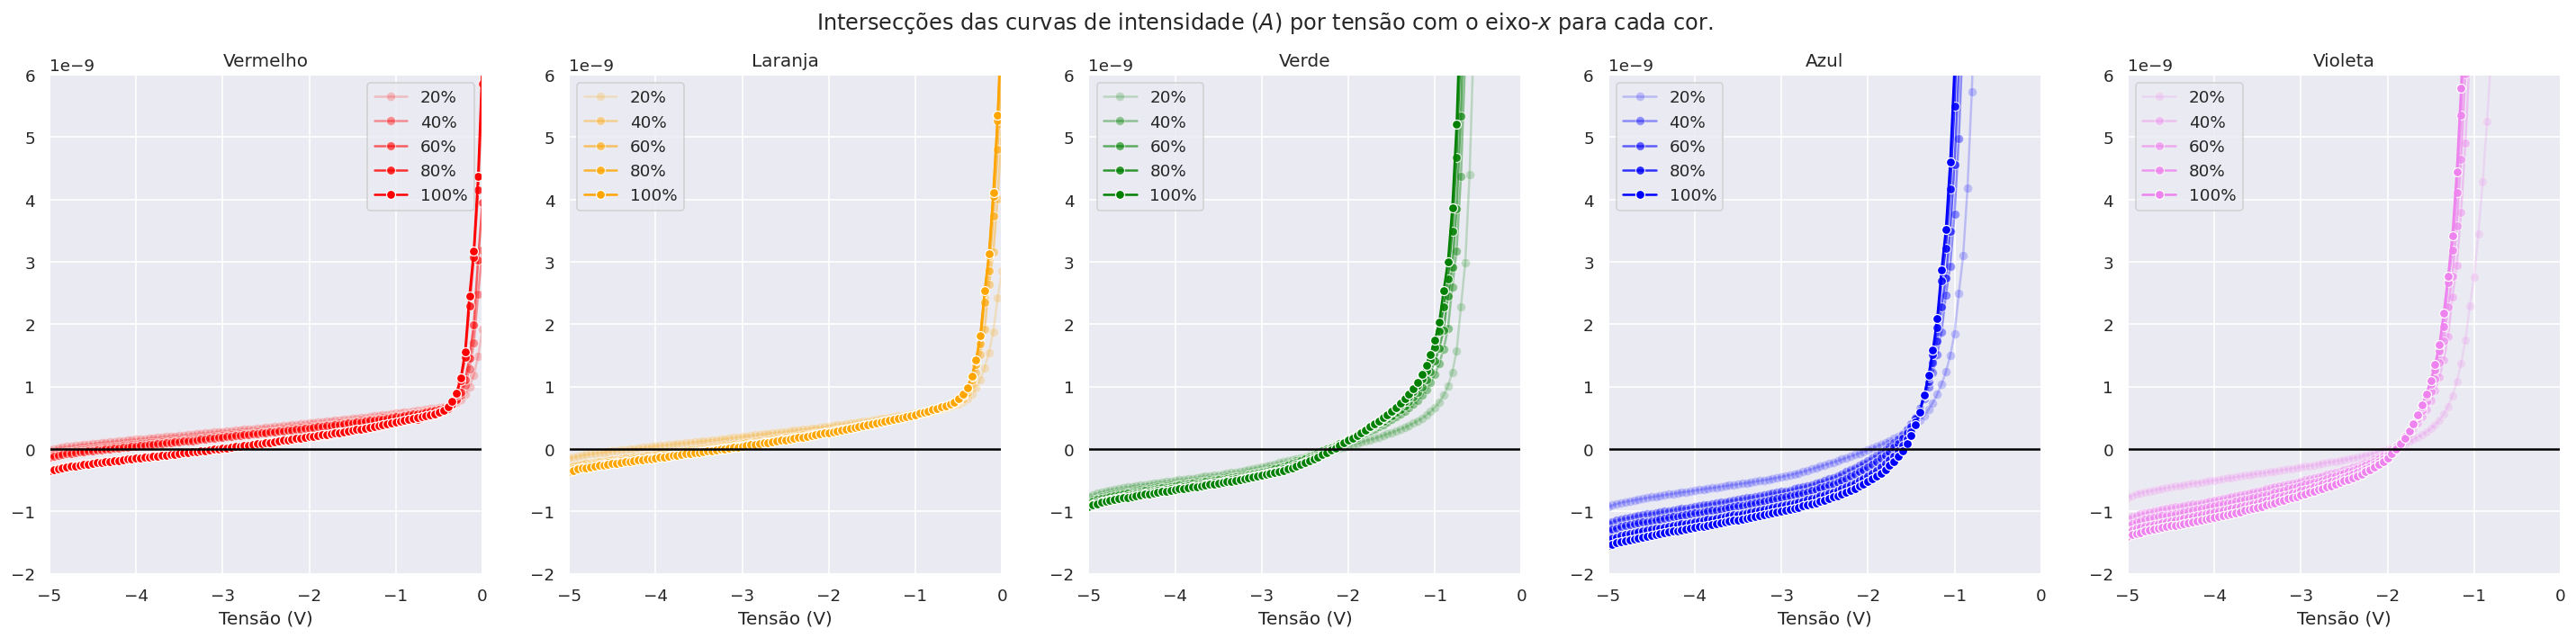

In [90]:
fig, axs = plt.subplots(1, len(cores), figsize=(30,6), gridspec_kw={  })
plt.suptitle('Intersecções das curvas de intensidade ($A$) por tensão com o eixo-$x$ para cada cor.')

ylims = [ (-2E-9, 6E-9), (-2E-9, 6E-9), (-2E-9, 6E-9), (-2E-9, 6E-9), (-2E-9, 6E-9) ]
for i,cor in enumerate(cores):

	for j,inte in enumerate(intensities):
		sns.lineplot(data=df, x='Tensao', y=f'{cor}_{inte}', color=colors_[i], marker='o', alpha=inte/100, label=f'{inte}%', ax=axs[i])

	axs[i].hlines(y=0, xmin=-5, xmax=5, color='black')
	axs[i].set( xlim=(-5, 0), ylim=ylims[i], title=cor, xlabel='Tensão (V)', ylabel='')

plt.savefig('Plots/curves_lines_fit_intersection.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

In [91]:
cutoffs = []
limits = [ 0.75E-9, 0.9E-9, 1.0E-9, 0.2E-9, 0.0E-9 ]

for i,cor in enumerate(cores):
	v0s = []

	for inte in intensities:
		name = f'{cor}_{inte}'
		linear = lambda x, a, b: a * x + b

		data1 = df.loc[(df['Tensao'] < 0) & (df[name] > limits[i])]
		data2 = df.loc[(df['Tensao'] < 0) & (df[name] < limits[i])]

		fit1 = curve_fit(linear, xdata=data1['Tensao'], ydata=data1[name])
		fit2 = curve_fit(linear, xdata=data2['Tensao'], ydata=data2[name])

		(a, b), (c, d) = fit1[0], fit2[0]

		v0 = (d - b) / (a - c)
		v0s.append(v0)

	print(f'{cor}:\t{v0s}')
	cutoffs.append([ -np.mean(v0s), np.std(v0s) + 0.05 ])

cutoffs = np.array(cutoffs)

Vermelho:	[-0.26586694086269697, -0.2860817251940178, -0.284041701691844, -0.29670693696068673, -0.3257400146766562]
Laranja:	[-0.32509932302054956, -0.3819978050225506, -0.38116944763582306, -0.3799977145731543, -0.3793101924861033]
Verde:	[-0.6848185826236276, -0.8148503200509877, -0.8795826354349656, -0.9136471423532894, -0.9145227280893774]
Azul:	[-1.2277372979797339, -1.201227543820219, -1.1713599038610905, -1.1418050769505297, -1.1434191323047378]
Violeta:	[-1.461928932546103, -1.433832776086325, -1.4347182680480925, -1.4351511248758324, -1.4038636768061428]


In [92]:
cutoffs

array([[0.29168746, 0.06970458],
       [0.3695149 , 0.07222715],
       [0.84148428, 0.13631001],
       [1.17710979, 0.08334473],
       [1.43389896, 0.068385  ]])

In [93]:
popt, pcov = curve_fit(
	lambda x, a, b: a * x + b,
	xdata=leds_frequency.transpose()[0],
	ydata=cutoffs.transpose()[0],
	sigma=cutoffs.transpose()[1]
)

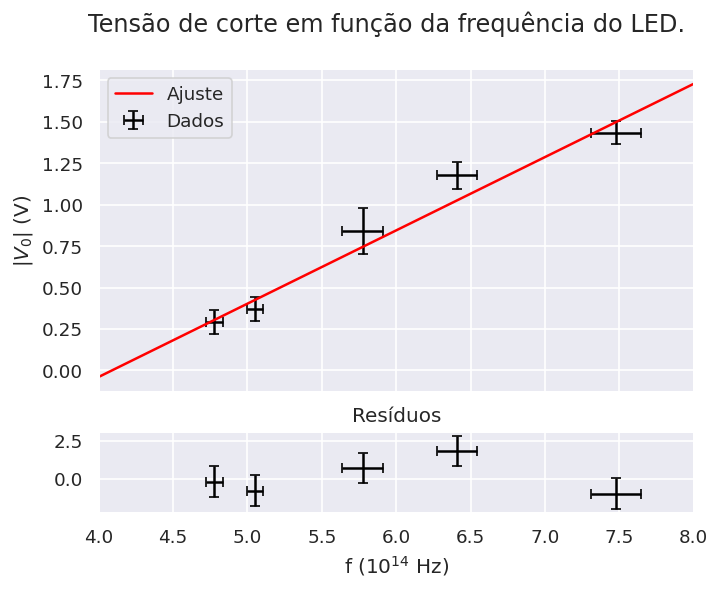

In [94]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={ 'hspace': 0.2, 'height_ratios': (4, 1)})
plt.suptitle('Tensão de corte em função da frequência do LED.')

axs[0].errorbar(
    x=leds_frequency.transpose()[0] / 1E14,
    y=cutoffs.transpose()[0],
    xerr=leds_frequency.transpose()[1] / 1E14,
	yerr=cutoffs.transpose()[1],
    fmt=' ', marker=' ', color='black', capsize=3, label='Dados'
)

x = np.linspace(4, 8, 10) * 1E14
sns.lineplot(x=x/1E14, y=x*popt[0]+popt[1], color='red', label='Ajuste', ax=axs[0])

axs[1].errorbar(
    x=leds_frequency.transpose()[0] / 1E14,
    y=(cutoffs.transpose()[0] - leds_frequency.transpose()[0] * popt[0] - popt[1]) / cutoffs.transpose()[1],
    xerr=leds_frequency.transpose()[1] / 1E14,
	yerr=1,
    fmt=' ', marker=' ', color='black', capsize=3
)

axs[0].set(ylabel='$|V_0|$ (V)')
axs[1].set(xlim=(4, 8), xlabel='f ($10^{14}$ Hz)', ylabel='', title='Resíduos')

plt.savefig('Plots/cutoff_intensity_method2.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

In [98]:
print('Constante de Planck:\t{:.8e} | {:.8e} | {:.2f}% | {:.1f}'.format(popt[0], np.sqrt(pcov[0][0]), 100*(h-popt[0])/h, (h - popt[0]) / np.sqrt(pcov[0][0])))
print('Função Trabalho:\t{:.8e} | {:.8e}'.format(-popt[1], np.sqrt(pcov[1][1])))

Constante de Planck:	4.42446454e-15 | 4.29680724e-16 | -6.98% | -0.7
Função Trabalho:	1.80977075e+00 | 2.58356804e-01


In [96]:
chi2 = np.sum((cutoffs.transpose()[0] - leds_frequency.transpose()[0] * popt[0] - popt[1])**2 / cutoffs.transpose()[1]**2)
print(chi2)

5.369956234641211


In [97]:
print(chi2 / 3)

1.7899854115470701


### Método 3

O terceiro método consiste em determinar os pontos de intersecção entre os pares de linha para cada cor e intensidade, e assim, determinar o valor de $V_0$.

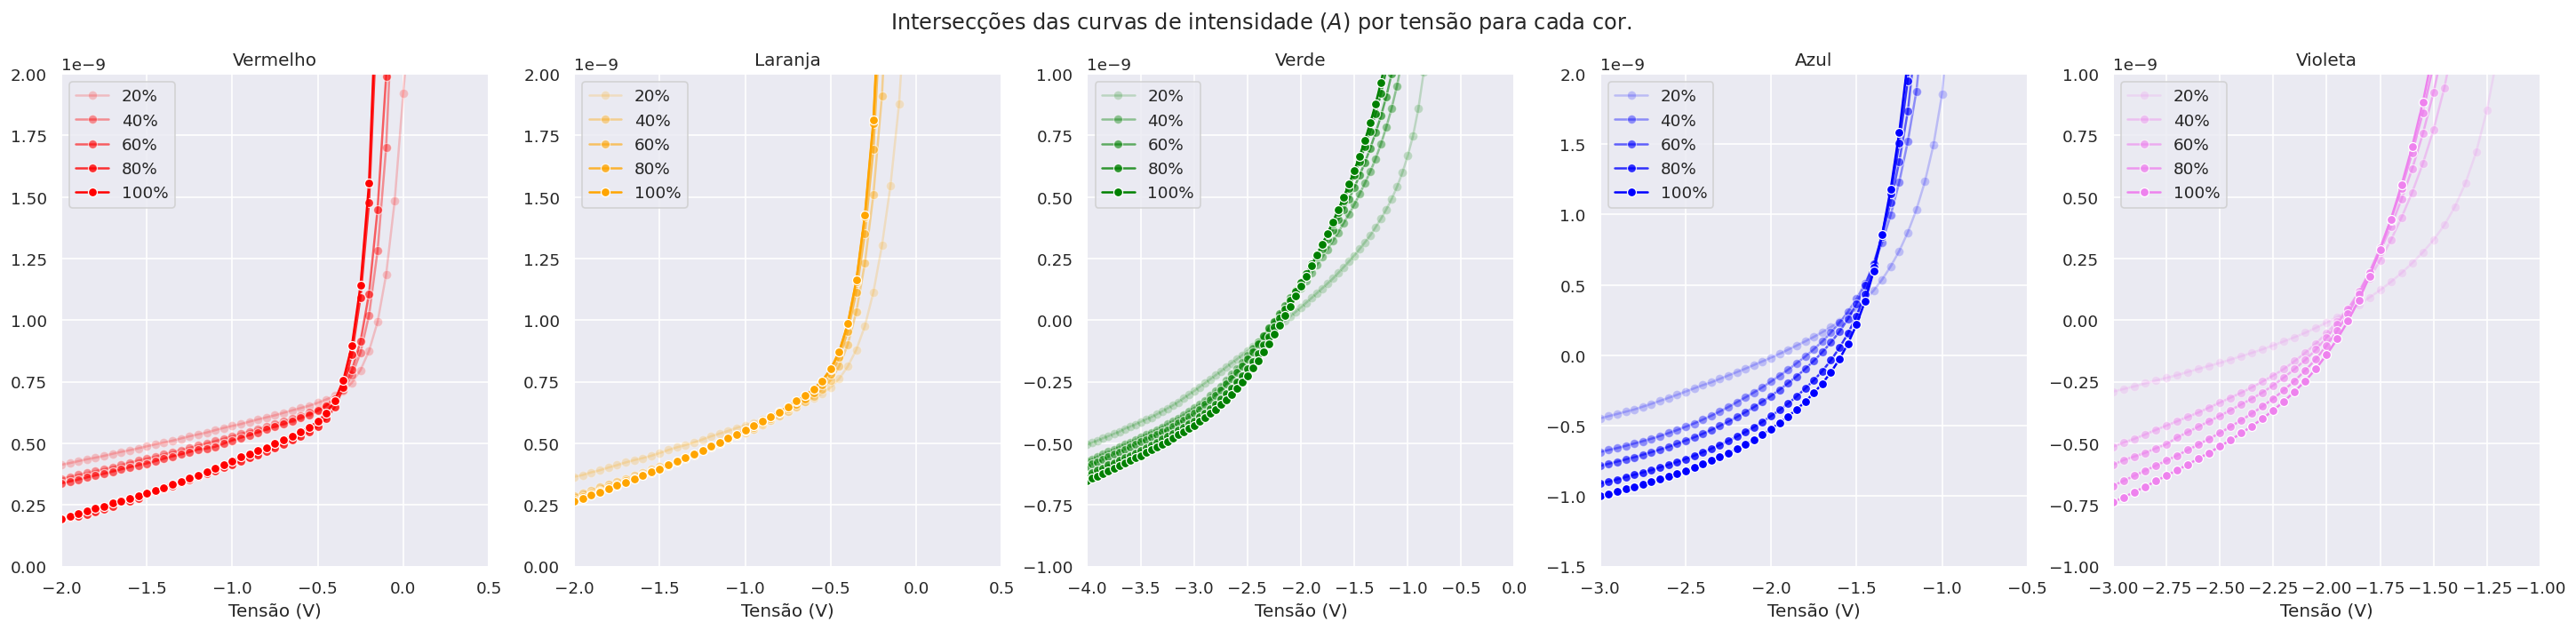

In [99]:
fig, axs = plt.subplots(1, len(cores), figsize=(30,6), gridspec_kw={  })
plt.suptitle('Intersecções das curvas de intensidade ($A$) por tensão para cada cor.')

xlims = [ (-2, 0.5), (-2, 0.5), (-4, 0), (-3, -0.5), (-3, -1) ]
ylims = [ (0, 2E-9), (0E-9, 2E-9), (-1E-9, 1E-9), (-1.5E-9, 2E-9), (-1E-9, 1E-9) ]
for i,cor in enumerate(cores):

	for j,inte in enumerate(intensities):
		sns.lineplot(data=df, x='Tensao', y=f'{cor}_{inte}', color=colors_[i], marker='o', alpha=inte/100, label=f'{inte}%', ax=axs[i])

	axs[i].set( xlim=xlims[i], ylim=ylims[i], title=cor, xlabel='Tensão (V)', ylabel='')

plt.savefig('Plots/curves_intersection.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

In [120]:
cutoffs = list([])

for i,cor in enumerate(cores):
	data = []

	for j,intensity in enumerate(intensities):
		name = f'{cor}_{intensity}'
		data.append(list(df[name]))
	data = np.array(data)

	v0s = []
	for j in range(len(data)):
		for k in range(j+1, len(data)):
			delta = -np.abs(data[k] - data[j])
			v0s.append( df['Tensao'][np.argmax(delta)] )

	print(f'{cor}\t{v0s}')
	cutoffs.append([ -np.mean(v0s), np.std(v0s) + 0.05 ])

cutoffs = np.array(cutoffs)

Vermelho	[-0.35, -0.4, -0.35, -0.4, -0.4, -0.35, -0.4, -0.35, -0.4, -2.35]
Laranja	[-0.65, -0.75, -0.8, -0.8, -1.15, -1.15, -1.25, -1.15, -1.35, -4.8]
Verde	[-2.4, -2.4, -2.25, -2.2, -2.35, -2.15, -2.05, -2.0, -1.9, -1.8]
Azul	[-1.6, -1.55, -1.45, -1.45, -1.4, -1.4, -1.4, -1.35, -1.35, -1.35]
Violeta	[-1.9, -1.9, -1.9, -1.85, -1.9, -1.85, -1.8, -1.8, -1.75, -1.7]


In [121]:
cutoffs

array([[0.575     , 0.64213596],
       [1.385     , 1.21082944],
       [2.15      , 0.24874607],
       [1.43      , 0.13124038],
       [1.835     , 0.11726812]])

In [122]:
popt, pcov = curve_fit(
	lambda x, a, b: a * x + b,
	xdata=leds_frequency.transpose()[0],
	ydata=cutoffs.transpose()[0],
	sigma=cutoffs.transpose()[1]
)

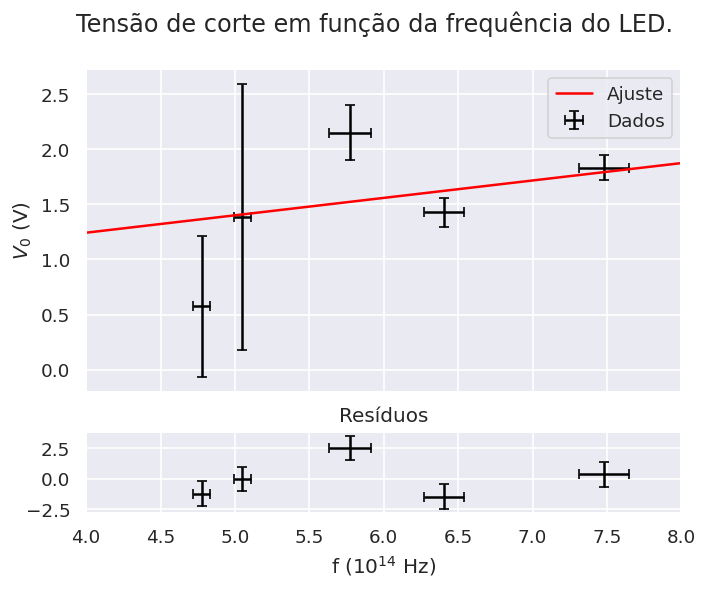

In [123]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={ 'hspace': 0.2, 'height_ratios': (4, 1)})
plt.suptitle('Tensão de corte em função da frequência do LED.')

axs[0].errorbar(
    x=leds_frequency.transpose()[0] / 1E14,
    y=cutoffs.transpose()[0],
    xerr=leds_frequency.transpose()[1] / 1E14,
	yerr=cutoffs.transpose()[1],
    fmt=' ', marker=' ', color='black', capsize=3, label='Dados'
)

x = np.linspace(4, 8, 10) * 1E14
sns.lineplot(x=x/1E14, y=x*popt[0]+popt[1], color='red', label='Ajuste', ax=axs[0])

axs[1].errorbar(
    x=leds_frequency.transpose()[0] / 1E14,
    y=(cutoffs.transpose()[0] - leds_frequency.transpose()[0] * popt[0] - popt[1]) / cutoffs.transpose()[1],
    xerr=leds_frequency.transpose()[1] / 1E14,
	yerr=1,
    fmt=' ', marker=' ', color='black', capsize=3
)

axs[0].set(ylabel='$V_0$ (V)')
axs[1].set(xlim=(4, 8), xlabel='f ($10^{14}$ Hz)', title='Resíduos')

plt.savefig('Plots/cutoff_intensity_method3.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

In [124]:
print('Constante de Planck:\t{:.8e} | {:.8e} | {:.2f}% | {:.1f}'.format(popt[0], np.sqrt(pcov[0][0]), 100*(h-popt[0])/h, (h - popt[0]) / np.sqrt(pcov[0][0])))
print('Função Trabalho:\t{:.8e} | {:.8e}'.format(-popt[1], np.sqrt(pcov[1][1])))

Constante de Planck:	1.58060633e-15 | 2.17692850e-15 | 61.78% | 1.2
Função Trabalho:	-6.10852954e-01 | 1.49359602e+00


In [125]:
chi2 = np.sum((cutoffs.transpose()[0] - leds_frequency.transpose()[0] * popt[0] - popt[1])**2 / cutoffs.transpose()[1]**2)
print(chi2)

10.16559314688575


In [126]:
chi2 / 3

3.3885310489619163

### Método 4

In [149]:
def ddIddT(sig, dT=0.05):
  return ((np.roll(sig, -1) - 2*sig + np.roll(sig, 1)) / dT**2)[1:-1]

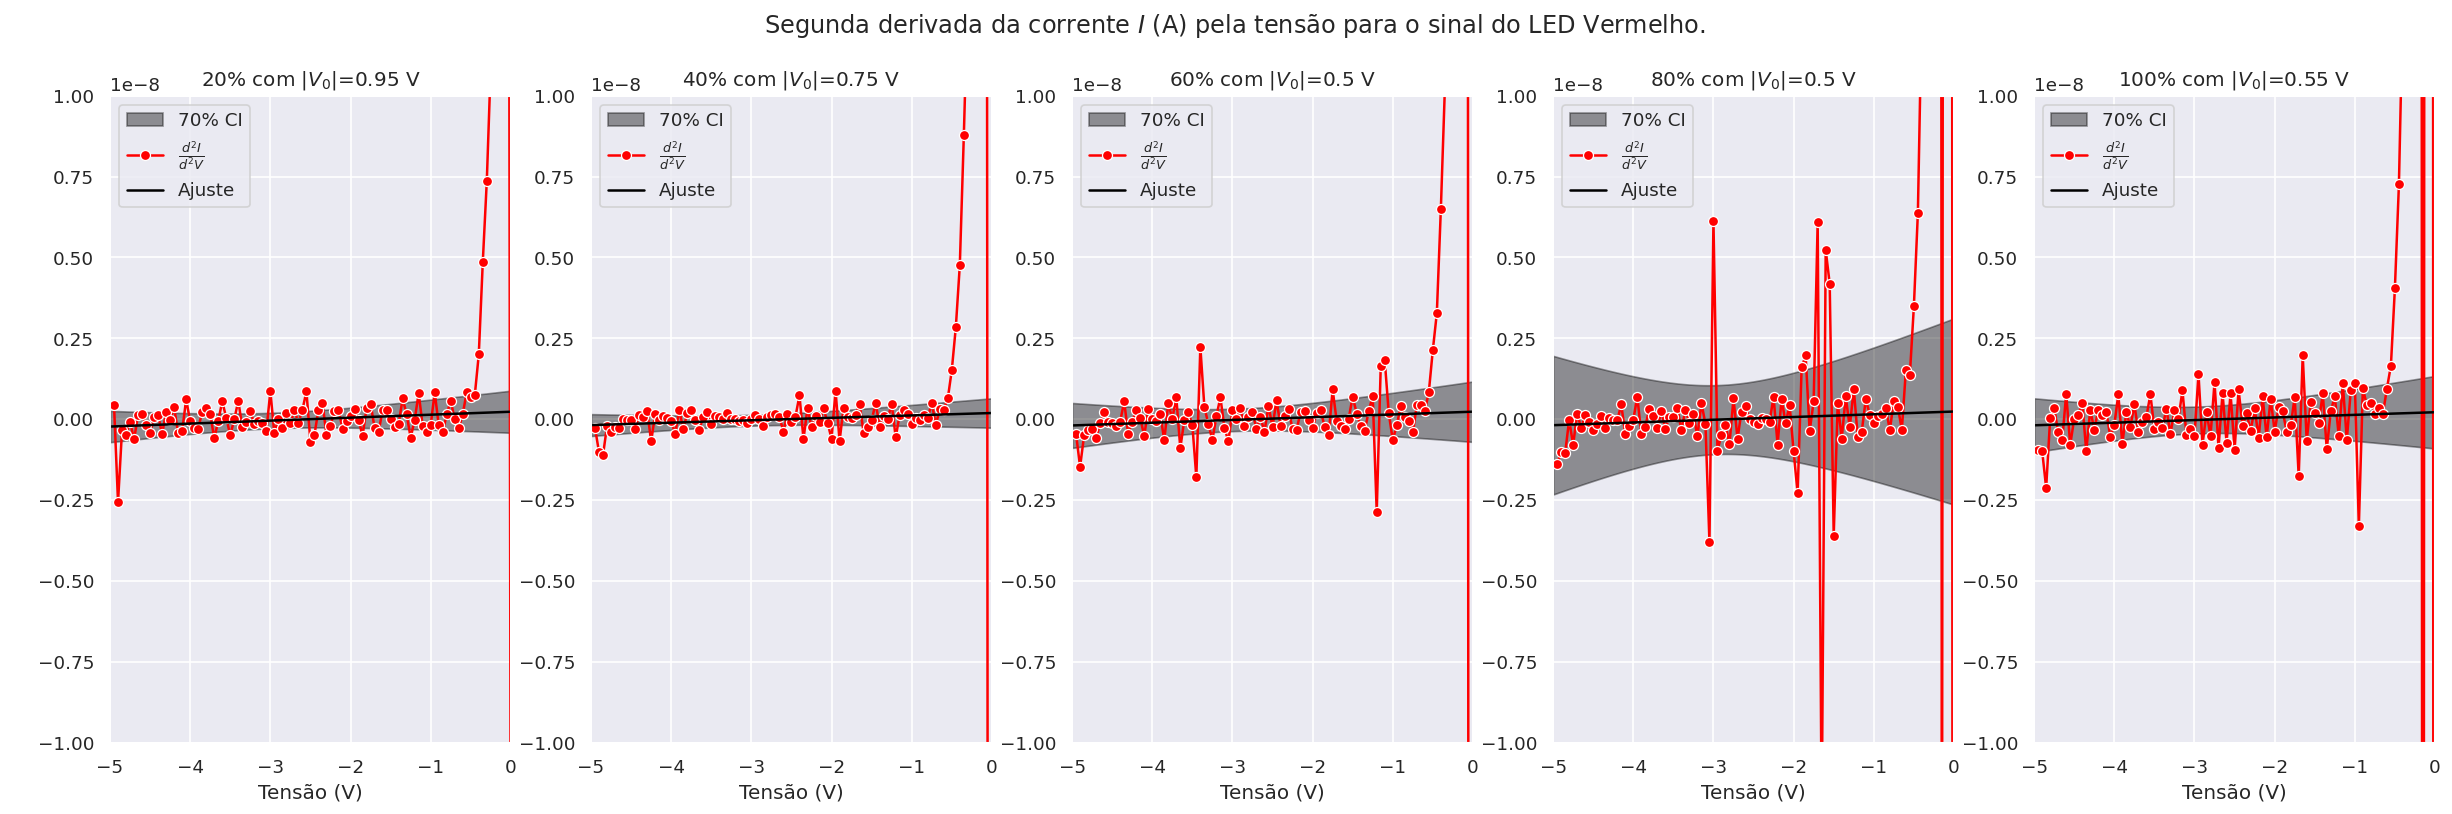

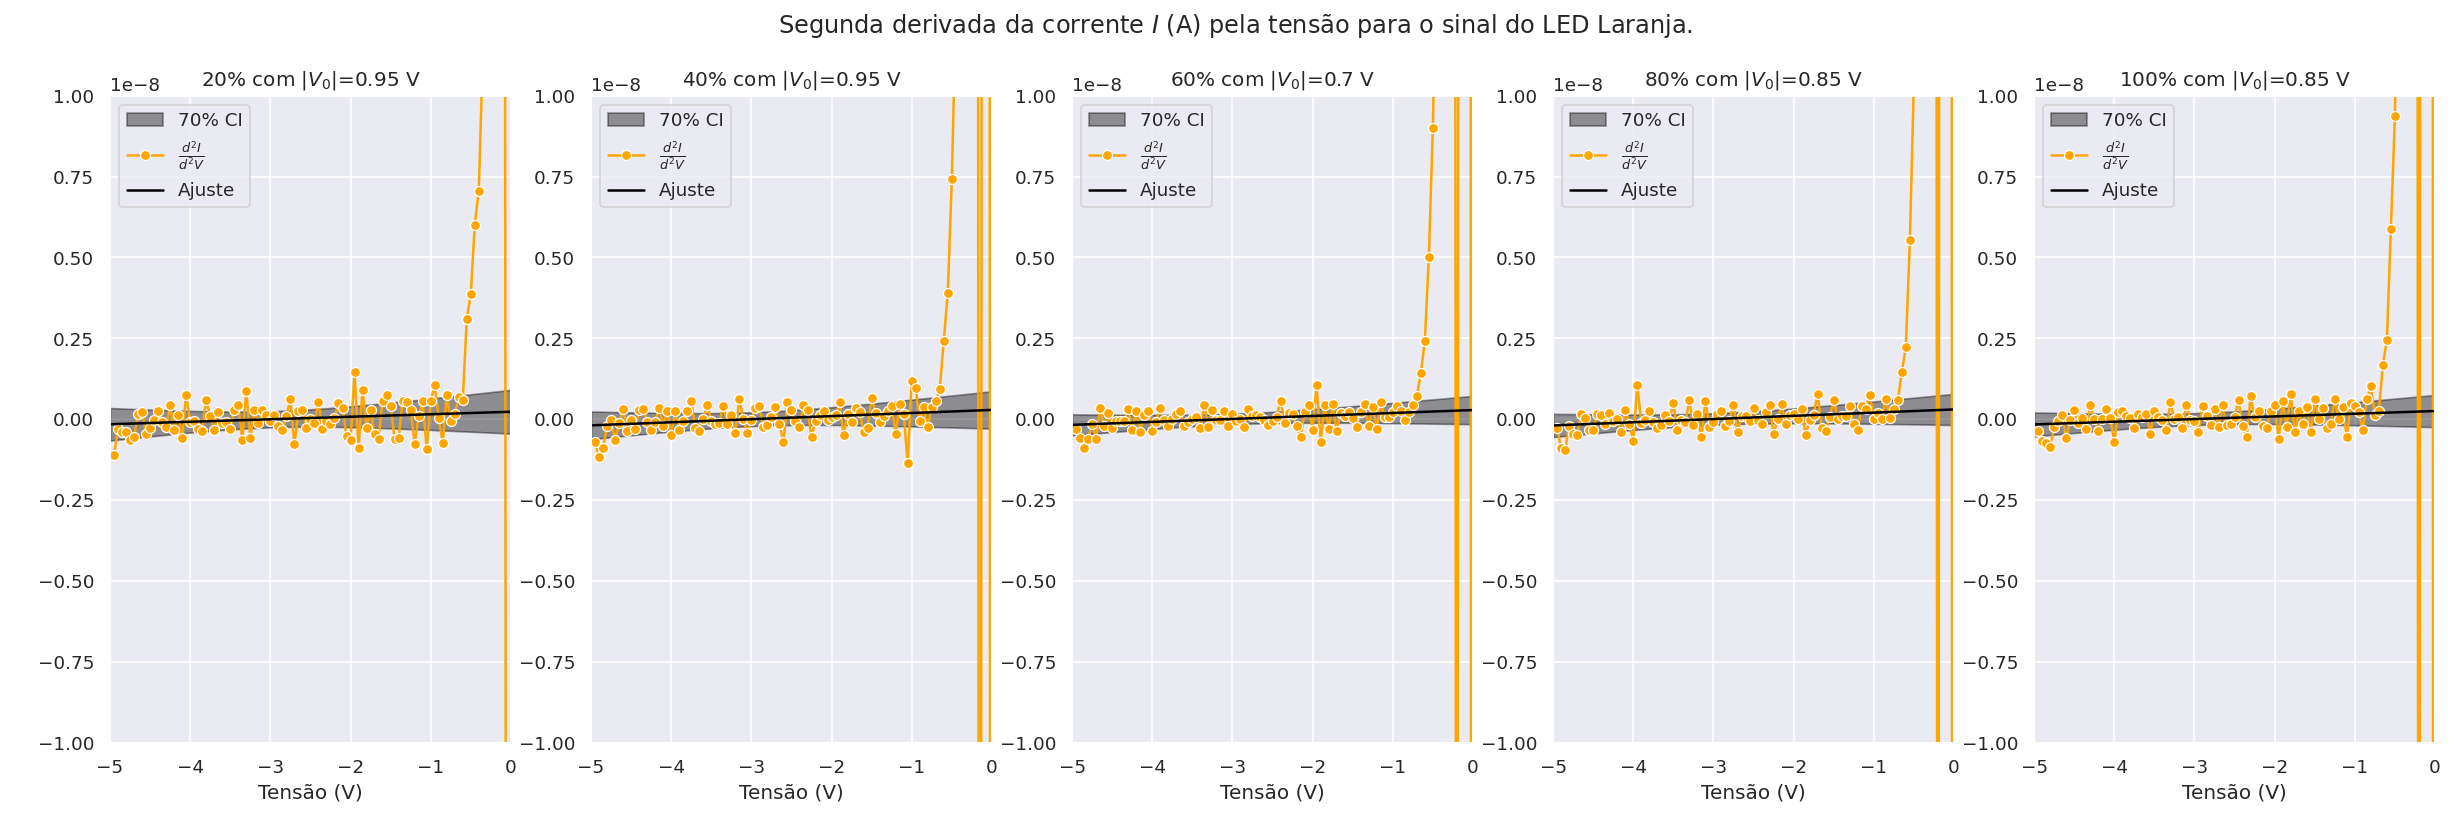

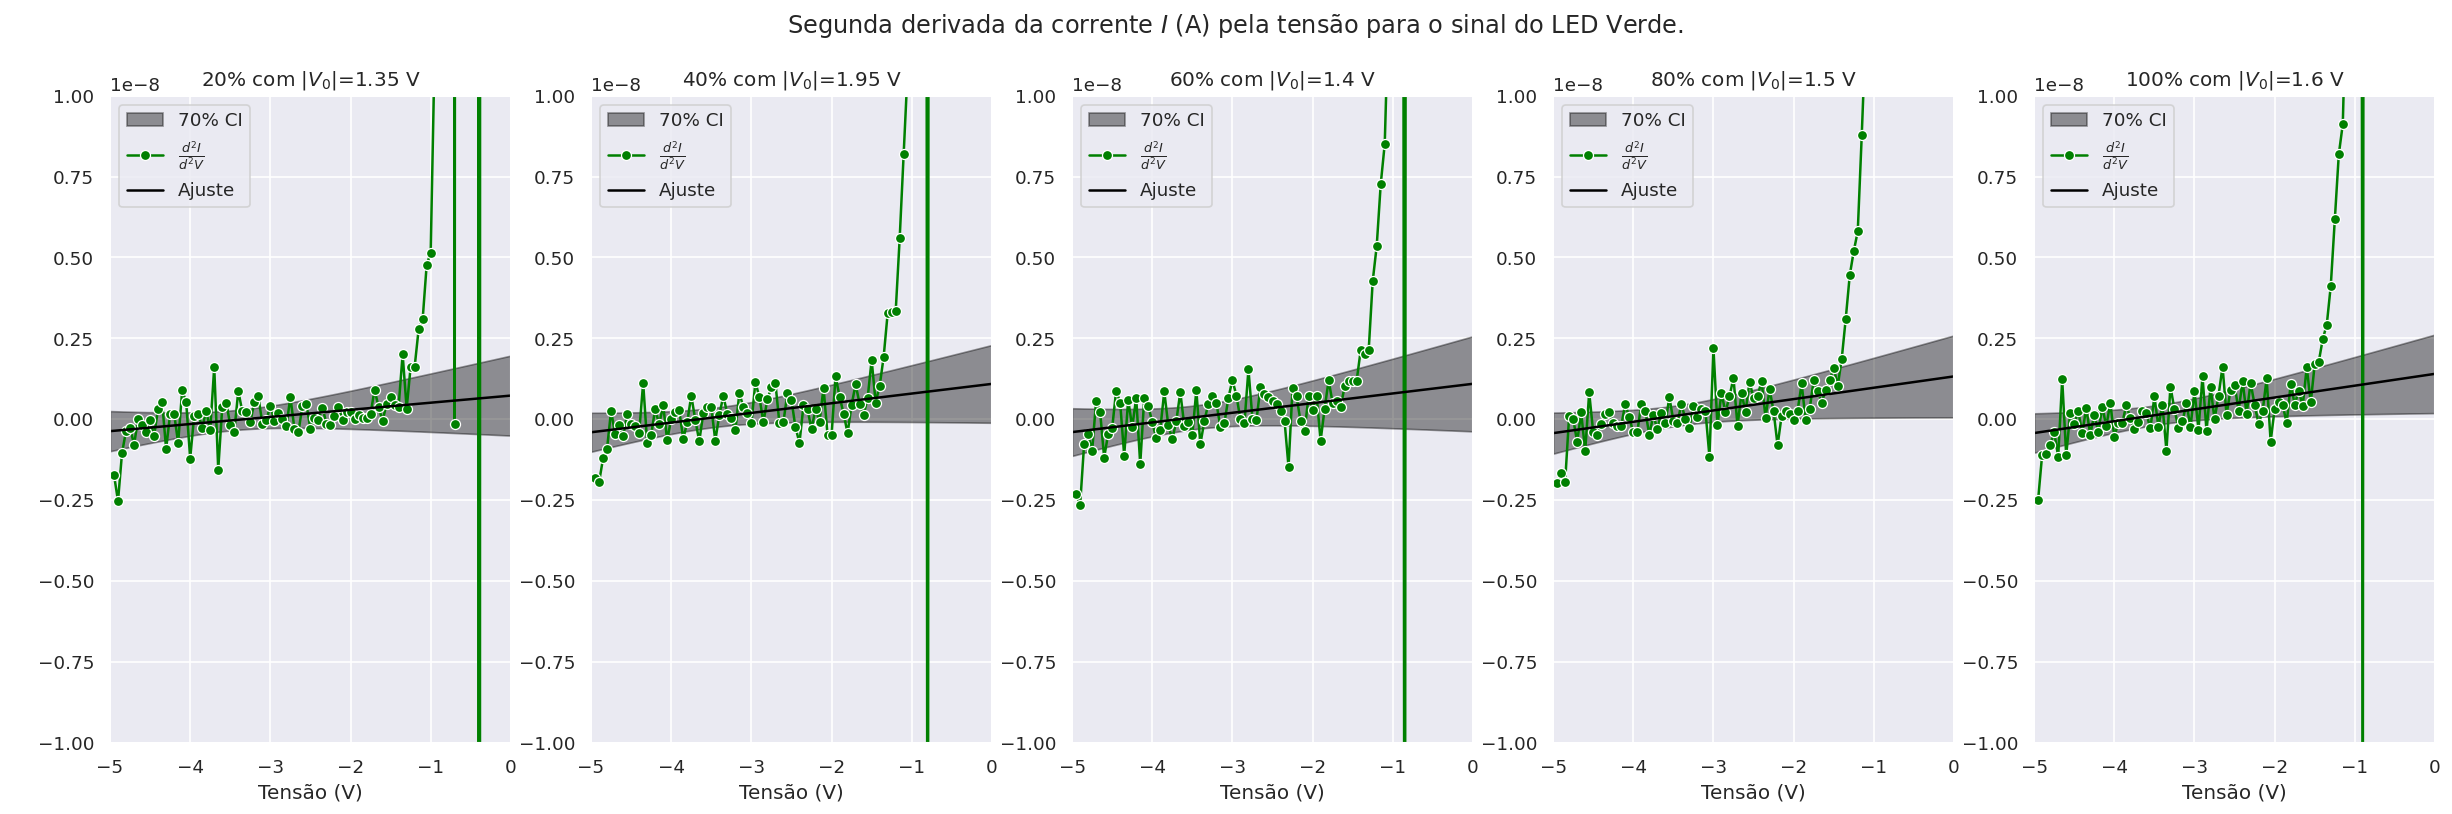

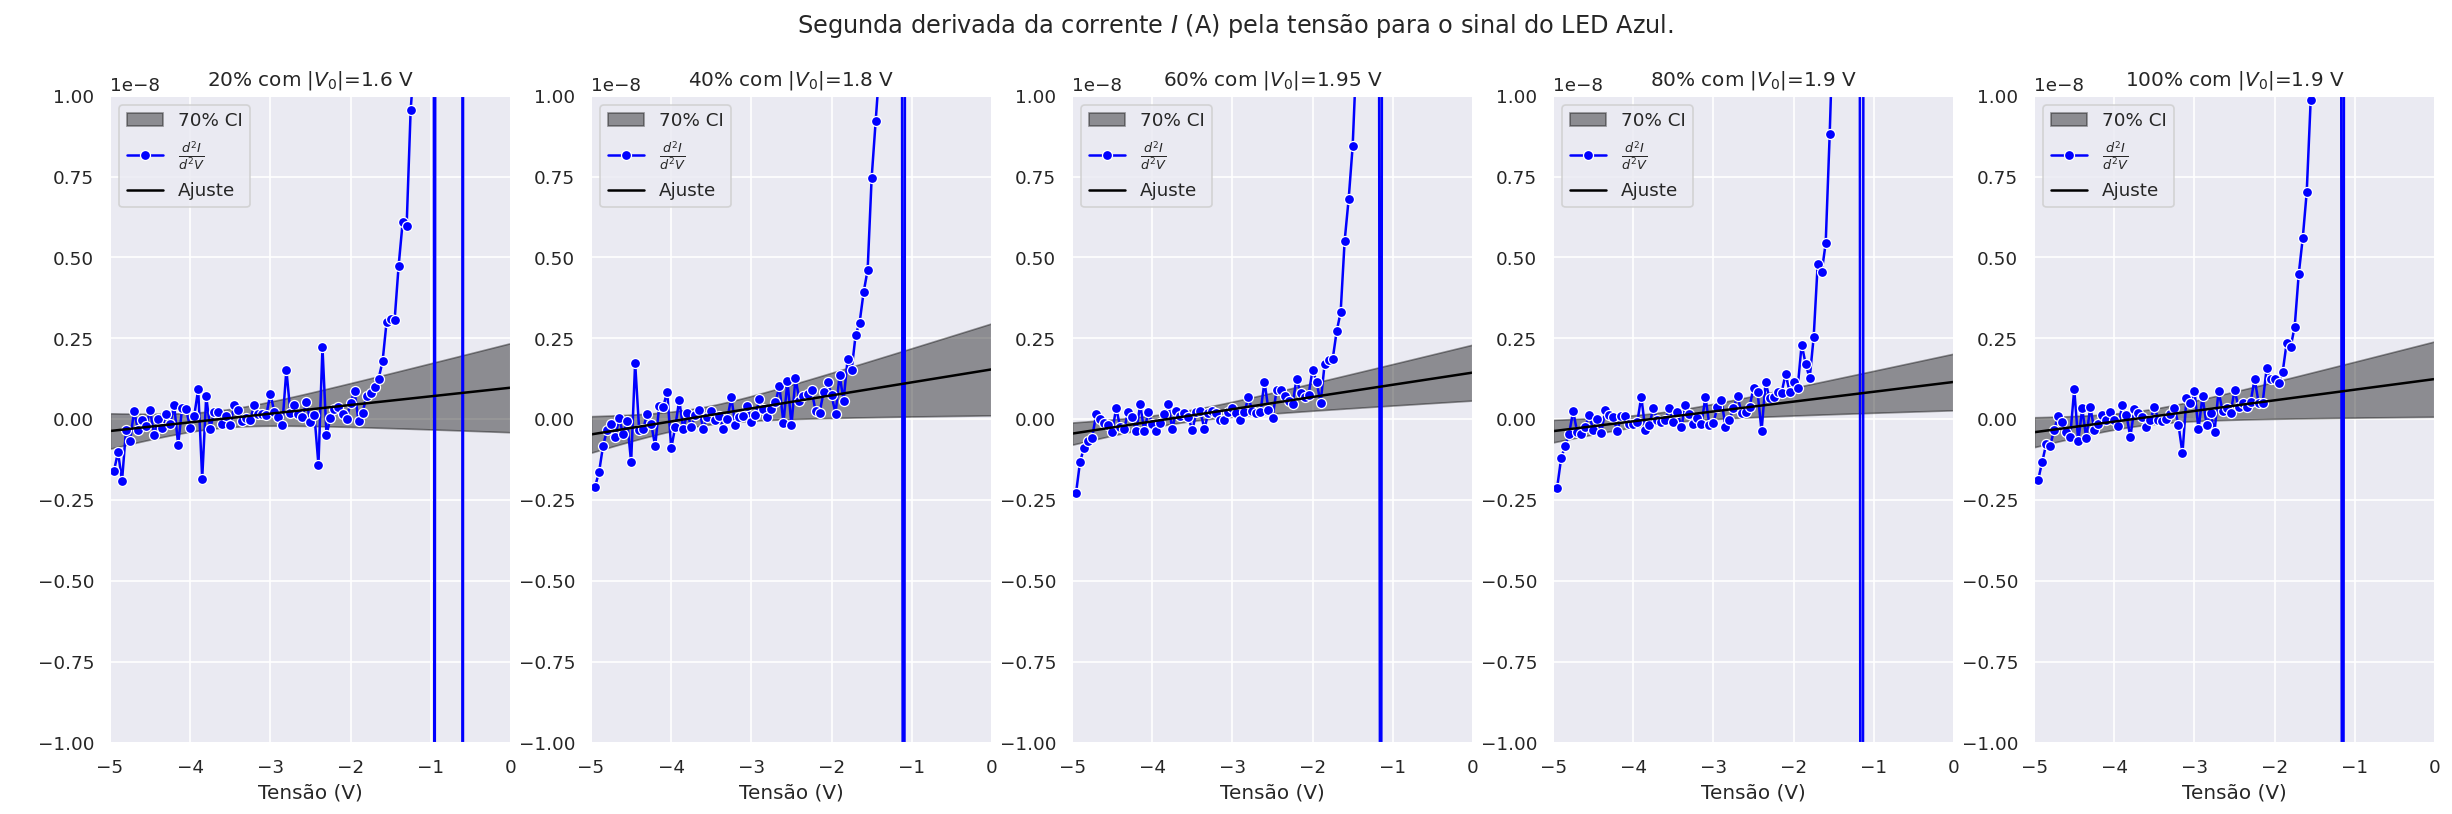

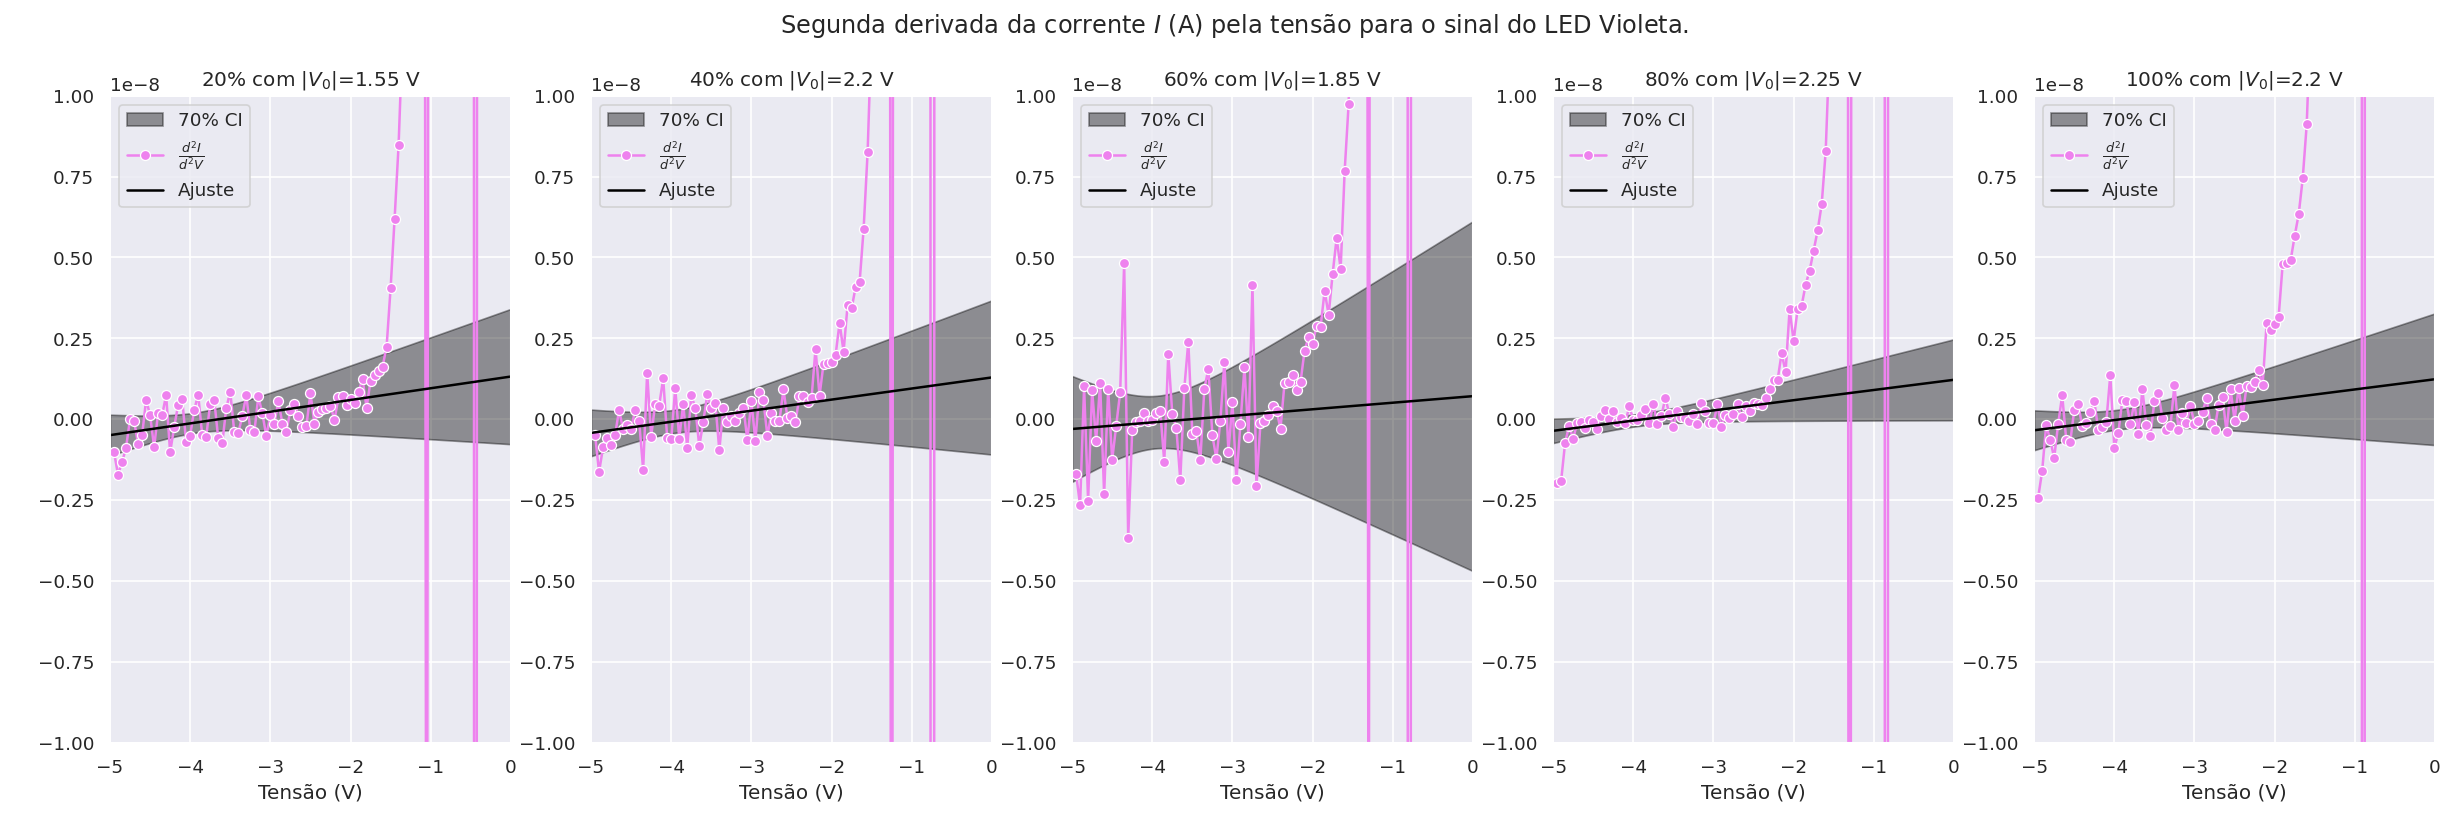

In [151]:
data		= []
limits 		= [ -1, -1, -2, -2.5, -3 ]
bounds 		= [ -1, -1, -2, -2, -2.5 ]
ylims		= ( (-0.5E-8, 0.5E-8), (-0.25E-8, 0.25E-8), (-0.5E-8, 0.5E-8), (-0.25E-8, 0.25E-8), (-0.75E-8, 0.75E-8) )
cutoffs 	= []

for i,cor in enumerate(cores[:]):
    fig, axs = plt.subplots(1, 5, figsize=(25,7), gridspec_kw={  })
    plt.suptitle(f'Segunda derivada da corrente $I$ (A) pela tensão para o sinal do LED {cor}.')

    v0s = []
    data.append([])

    for j,inte in enumerate(intensities):
        data[i].append(ddIddT(df[f'{cor}_{inte}']))

        n = len(df.loc[(df['Tensao'] >= -5) & (df['Tensao'] <= limits[i])]['Tensao'])

        xdata, ydata = df['Tensao'][1:n+1], data[i][j][1:n+1]

        fit = curve_fit(
            lambda x, a, b: a * x + b,
            xdata=xdata,
            ydata=ydata
        )

        x = np.linspace(-5, 0, 100)
        y = fit[0][0] * x + fit[0][1]

        # Cálculo do intervalo de confiança
        S_xy    = np.sqrt( np.mean(( ydata - fit[0][0] * xdata - fit[0][1] )**2) )
        S_xx    = np.std(xdata)**2
        t_crit  = 1.050 / 2


        # Determinação da tensão de corte
        error = t_crit * S_xy * np.sqrt(1 + 1/n + (df['Tensao'][1:-1] - np.mean(xdata))**2 / S_xx )
        arr = data[i][j] - (fit[0][0] * df['Tensao'][1:-1] + fit[0][1] + error)

        v0 = 0
        for k,value in enumerate(arr):
            v = df['Tensao'][k+1]
            if v > bounds[i]:
                if value > 0:
                    v0 = v
                    break

        v0s.append(v0)

        # Plot
        delta = t_crit * S_xy * np.sqrt(1 + 1/n + (x - np.mean(xdata))**2 / S_xx )

        axs[j].fill_between(x=x, y1=y + delta, y2=y - delta, color='black', alpha=0.4, label='70% CI')

        sns.lineplot(x=df['Tensao'][1:-1], y=data[i][j], color=colors_[i], ax=axs[j], marker='o', label='$\\frac{d^2 I}{d^2 V}$')
        sns.lineplot(x=x, y=y, color='black', ax=axs[j], label='Ajuste')

        axs[j].set(ylim=(-1E-8, 1E-8), xlim=(-5, -0), title=f'{inte}% com $|V_0$|={-v0} V', ylabel=' ', xlabel='Tensão (V)' ) 

    cutoffs.append([ -np.mean(v0s), np.std(v0s) + 0.05 ])

    plt.savefig(f'Plots/2nd_derivative_{colors[i]}.png', dpi=300, facecolor='white', bbox_inches='tight')
    plt.show()

cutoffs = np.array(cutoffs)

In [152]:
cutoffs

array([[0.65      , 0.22606817],
       [0.86      , 0.14165151],
       [1.56      , 0.26307276],
       [1.83      , 0.17489996],
       [2.01      , 0.32092434]])

In [153]:
popt, pcov = curve_fit(
	lambda x, a, b: a * x + b,
	xdata=leds_frequency.transpose()[0],
	ydata=cutoffs.transpose()[0],
    sigma=cutoffs.transpose()[1]
)

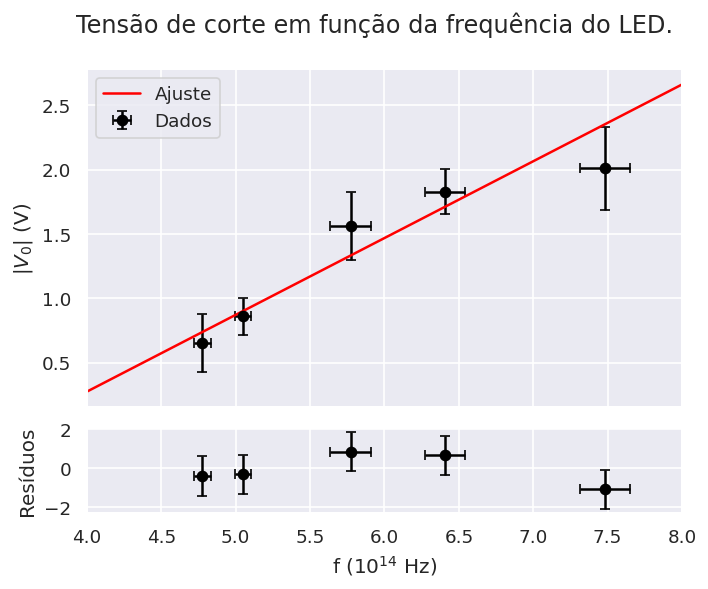

In [154]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={ 'hspace': 0.1, 'height_ratios': (4, 1)})
plt.suptitle('Tensão de corte em função da frequência do LED.')

axs[0].errorbar(
    x=leds_frequency.transpose()[0] / 1E14,
    y=cutoffs.transpose()[0],
    xerr=leds_frequency.transpose()[1] / 1E14,
	yerr=cutoffs.transpose()[1],
    fmt=' ', marker='o', color='black', capsize=3, label='Dados'
)

x = np.linspace(4, 8, 10) * 1E14
sns.lineplot(x=x/1E14, y=x*popt[0]+popt[1], color='red', label='Ajuste', ax=axs[0])

axs[1].errorbar(
    x=leds_frequency.transpose()[0] / 1E14,
    y=(cutoffs.transpose()[0] - leds_frequency.transpose()[0] * popt[0] - popt[1]) / cutoffs.transpose()[1],
    xerr=leds_frequency.transpose()[1] / 1E14,
	yerr=1,
    fmt=' ', marker='o', color='black', capsize=3
)

axs[0].set(ylabel='|$V_0$| (V)')
axs[1].set(xlim=(4, 8), xlabel='f ($10^{14}$ Hz)', ylabel='Resíduos')

plt.savefig('Plots/cutoff_intensity_method4.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

In [155]:
print('Constante de Planck:\t{:.8e} | {:.8e} | {:.2f}% | {:.1f}'.format(popt[0], np.sqrt(pcov[0][0]), 100*(h-popt[0])/h, (h - popt[0]) / np.sqrt(pcov[0][0])))
print('Função Trabalho:\t{:.8e} | {:.8e}'.format(-popt[1], np.sqrt(pcov[1][1])))

Constante de Planck:	5.97122723e-15 | 1.00917950e-15 | -44.38% | -1.8
Função Trabalho:	2.11393983e+00 | 5.74001906e-01


In [156]:
chi2 = np.sum((cutoffs.transpose()[0] - leds_frequency.transpose()[0] * popt[0] - popt[1])**2 / cutoffs.transpose()[1]**2)
print(chi2)

2.5743727721107317


In [157]:
chi2 / 3

0.8581242573702439